In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/drussellmrichie/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# domains = ['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']
# dims = [('sincere','exciting'),
#         ('hedonic','utilitarian'),
#         ('masculine','feminine'),
#         ('tasty','nutritious'),
#         ('significance','autonomy'),
#         ('dread-inducing','unknowable'),
#         ('warm', 'competent')]

domains = ['trait', 'risk', 'people', 'food', 'occupation', 'brand', 'good']
dims = [('masculine', 'feminine'),
       ('dread-inducing', 'unknowable'),
       ('warm', 'competent'),
       ('tasty', 'nutritious'),
       ('significance', 'autonomy'),
       ('sincere', 'exciting'),
       ('hedonic', 'utilitarian')]

flattened_dims = [dim for x in dims for dim in x]

In [3]:
with open("data/dict_of_Xs.pickle", "rb") as handle:
    dict_of_Xs = pickle.load(handle)
    
with open("data/dict_of_ys.pickle", "rb") as handle:
    dict_of_ys = pickle.load(handle)

In [4]:
ridge = Ridge(alpha=10) # pre-reg'd analyses revealed ridge with alpha=10 had highest rsquared across dimensions 

In [5]:
lr = LinearRegression()

In [6]:
# pca_dims = [1, 2, 3, 5, 10, 25, 50, 100, 200, 300]
pca_dims = [1, 2, 3, 5, 10, 25, 50, 100]

**Must fit PCA on just training set, not the entire dataset!!!**

https://arxiv.org/pdf/1901.08974.pdf

Fitting different PCA for each of ~200 LOO splits takes a bit of time -- the below takes ~4 minutes.

In [7]:
rs_by_judgment_and_pca_dim = []

for domain, dim_pair in tqdm(zip(domains, dims)):
    for dim in dim_pair:
        X = dict_of_Xs[domain]
        X = X.values
        y = dict_of_ys[dim]
        rs_by_pca_dim = []
        for pca_dim in pca_dims:
            pca = PCA(n_components=pca_dim)
#             X_dim_reduced = pca.fit_transform(X)
            loo = LeaveOneOut()
            y_preds = np.zeros(shape=len(y))
            for train_index, test_index in loo.split(X):
#             for train_index, test_index in loo.split(X_dim_reduced):
#                 X_train, X_test = X_dim_reduced[train_index], X_dim_reduced[test_index]
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
        
                X_train = pca.fit_transform(X_train)
#                 ridge.fit(X=X_train, y=y_train)
                lr.fit(X=X_train, y=y_train)
                
                X_test = pca.transform(X_test)
#                 y_pred = ridge.predict(X=X_test)[0]
                y_pred = lr.predict(X=X_test)[0]
                y_preds[test_index] = y_pred
            r, _ = pearsonr(y_preds, y)
            rs_by_pca_dim.append(r)
        # this next part just makes sure we have a column for the full, unreduced matrix, 300 if using googlenews word2vec
        loo = LeaveOneOut()
        y_preds = np.zeros(shape=len(y))
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            ridge.fit(X=X_train, y=y_train)

            y_pred = ridge.predict(X=X_test)[0]
            y_preds[test_index] = y_pred
        r, _ = pearsonr(y_preds, y)
        rs_by_pca_dim.append(r)
            
        rs_by_judgment_and_pca_dim.append(rs_by_pca_dim)

7it [02:55, 25.05s/it]


In [8]:
embedding_dimensionality = dict_of_Xs[domains[0]].shape[1]
pca_dims.append(embedding_dimensionality)

pca_results = pd.DataFrame(rs_by_judgment_and_pca_dim, index=flattened_dims, columns=pca_dims).T
pca_results.index.name = 'pcs_retained'
pca_results

,masculine,feminine,dread-inducing,unknowable,warm,competent,tasty,nutritious,significance,autonomy,sincere,exciting,hedonic,utilitarian
pcs_retained,,,,,,,,,,,,,,
1,0.315958,0.700315,0.442052,0.434184,0.218269,-0.168892,0.330299,0.242333,0.308603,0.313105,0.009467,0.173965,0.023076,0.131587
2,0.458176,0.697012,0.487276,0.481981,0.238994,0.432971,0.323724,0.610427,0.436279,0.407108,-0.032913,0.310933,0.374765,0.274114
3,0.486182,0.696712,0.511109,0.505779,0.308319,0.453548,0.313129,0.735537,0.423501,0.386305,0.043909,0.335137,0.611449,0.463759
5,0.620388,0.758262,0.781573,0.773394,0.354278,0.487058,0.430943,0.751772,0.633709,0.573088,0.026810,0.441355,0.689310,0.592340
10,0.648010,0.764326,0.835061,0.824165,0.695495,0.711574,0.559984,0.809231,0.694422,0.661668,0.479267,0.467168,0.757523,0.694373
25,0.685968,0.803671,0.854612,0.832949,0.734899,0.747869,0.654698,0.808741,0.783102,0.772357,0.515036,0.569732,0.807571,0.714653
50,0.669936,0.804553,0.863585,0.858576,0.760376,0.736071,0.598742,0.826310,0.803069,0.794834,0.576511,0.582563,0.825041,0.745068
100,0.683277,0.724242,0.845519,0.820285,0.782854,0.725021,0.589672,0.829329,0.802629,0.803236,0.572883,0.623284,0.831342,0.771101
300,0.730780,0.807277,0.875196,0.860895,0.786370,0.746171,0.657132,0.833428,0.817805,0.821766,0.594635,0.621086,0.842430,0.775557


In [9]:
# pca_results.to_csv('results/pca_then_regression/ridge_pca_pred_v_actual_correlations.csv')
pca_results.to_csv('results/pca_then_regression/linear_reg_pca_pred_v_actual_correlations.csv')

In [10]:
if 'pca_results' not in globals():
#     pca_results = pd.read_csv('results/pca_then_regression/ridge_pca_pred_v_actual_correlations.csv', index_col=0)
    pca_results = pd.read_csv('results/pca_then_regression/linear_reg_pca_pred_v_actual_correlations.csv', index_col=0)

In [11]:
# pca_results.T.plot(kind='bar', figsize=(20,6), colormap='Greens', rot=45);
# plt.savefig('figures/pca_results.png')

In [12]:
pca_results.columns = [x.capitalize() for x in pca_results.columns]

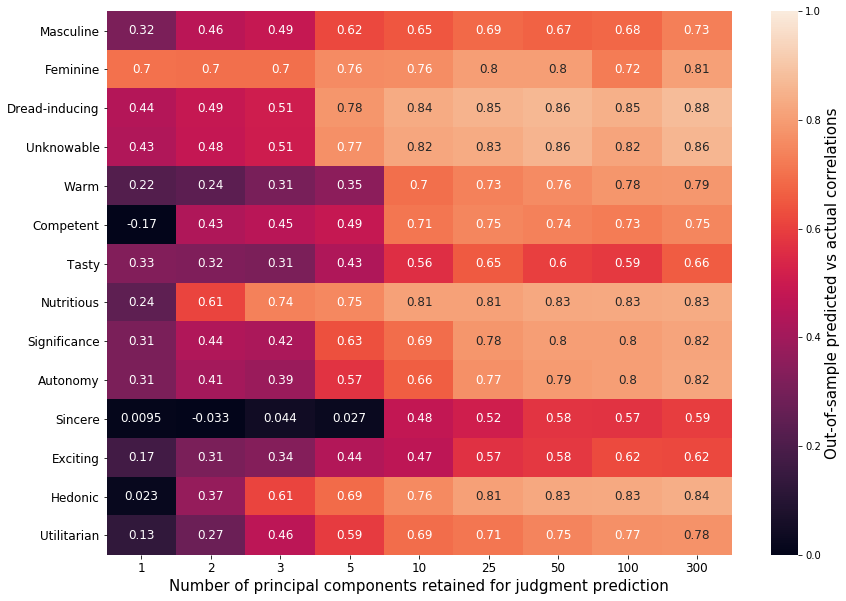

In [13]:
plt.subplots(figsize=(14,10));

ax = sns.heatmap(data=pca_results.T, vmin=0, vmax=1, annot=True, annot_kws={"size": 12},
                 cbar_kws={'label': "Out-of-sample predicted vs actual correlations"});

ax.set_xlabel('Number of principal components retained for judgment prediction', fontsize=15)
ax.tick_params(labelsize=12)

cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(15)

# plt.savefig('figures/pca_results_heatmap_shortened_fixed_pca.png')
# plt.savefig('figures/pca_results_heatmap_shortened_fixed_pca_high_res.png', dpi=500)

In [ ]:
# plt.subplots(figsize=(14,9));

# ax = sns.heatmap(data=pca_results.T, vmin=-1, vmax=1, annot=True, cmap='RdBu_r', cbar_kws={'label': "Correlation of actual and predicted judgments"});

# ax.set_xlabel('Number of principal components retained for judgment prediction', fontsize=15)
# ax.tick_params(labelsize=12)

# cbar_axes = ax.figure.axes[-1]
# cbar_axes.yaxis.label.set_size(15)

# plt.savefig('figures/pca_results_heatmap_shortened.png')